# Imports

In [164]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [211]:
def plot_correlation_heatmap(dataframe: pd.DataFrame, title: str):
    """
    Plot a triangle correlation heatmap with a color gradient from blue to red, using the data from the provided
    dataframe. The user should precise the plot title.
    Args:
        dataframe: a pandas dataframe containing values we want to correlate and represent their correlation
        title: string, the plot title
    """
    plt.figure(figsize=(12, 6))

    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(dataframe.corr(numeric_only=True), dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    heatmap = sns.heatmap(
        dataframe.corr(numeric_only=True),
        mask=mask,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        annot=True,
        linewidths=0.5,
    )
    heatmap.set_title(title, fontdict={"fontsize": 18}, pad=16)
    plt.show()

In [170]:
def separate_target_from_features(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_name: str,
    log_transformation: bool = False,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, np.array, np.array, np.array]:
    """
    From the three datasets (pandas dataframes, train, validation and test) containing all features and the
    target column, separate features and target to return three pandas dataframes containing only features and
    three numpy arrays containing target values. The target is selected according to the provided target_name.

    Args:
        train_df: pandas dataframe containing all training features and target values
        val_df: pandas dataframe containing all validation features and target values
        test_df: pandas dataframe containing all test features and target values

    Returns:
        train: pandas dataframe containing only features values for training dataset
        val: pandas dataframe containing only features values for validation dataset
        test: pandas dataframe containing only features values for test dataset
        y_train: numpy array containing train target values
        y_val: numpy array containing validation target values
        y_test: numpy array containing test target values
    """

    # Select the target values from original datasets
    y_train = train_df[target_name]
    y_val = val_df[target_name]
    y_test = test_df[target_name]

    # If the target value should be log transformed:
    if log_transformation:
        y_train = np.log1p(y_train)
        y_val = np.log1p(y_val)
        y_test = np.log1p(y_test)

    # Remove the target column from features dataset
    del train[target_name]
    del val[target_name]
    del test[target_name]

    return train, val, test, y_train, y_val, y_test

In [169]:
def prepare_feature_matrix_onehot(feature_df: pd.DataFrame) -> np.array:
    """
    From a pandas dataframe containing feature data (one feature per column), compute the feature matrix with one-hot encoding
    of the categorical columns.
    Categorical columns are one hot encoded using the DictVectorizer from sklearn.

    Args:
        feature_df: pandas dataframe containing feature data (one individual per row and one feature per column)

    Returns:
        feature_matrix: a numpy 2D array corresponding to the obtained feature matrix
    """

    feature_dicts = feature_df.to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    feature_matrix = dv.fit_transform(feature_dicts)

    return feature_matrix

In [238]:
def logistic_regression_accuracy(
    feature_list: List[str],
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    y_train: np.array,
    y_val: np.array,
    y_test: np.array,
) -> Tuple[float, float, float]:
    """
    Computes the accuracy of a logistic regression model trained on the provided training data, for training, validation
    and test data. The provided feature list is used to select the features in the feature matrices.
    The logistic regression model has these parameters (fixed for this exercise): solver="liblinear", C=1.0, max_iter=1000, random_state=42.

    Args:
        feature_list: list of strings containing the features we want to keep in our feature matrices.
        train_df: pandas dataframe containing the training dataset (features only)
        val_df: pandas dataframe containing the validation dataset (features only)
        test_df: pandas dataframe containing the test dataset (features only)
        y_train: numpy array containing the target values for the training dataset
        y_val: numpy array containing the target values for the validation dataset
        y_test: numpy array containing the target values for the test dataset

    Returns:
        score_train: float, the accuracy score obtained on the training dataset
        score_val: float, the accuracy score obtained on the validation dataset
        score_test: float, the accuracy score obtained on the test dataset
    """

    # Clearly state the features used
    print(f"The features used are {feature_list}.")

    # Keep the feature list in our feature dataframes
    train_features = train_df[feature_list]
    val_features = val_df[feature_list]
    test_features = test_df[feature_list]

    # Create the corresponding feature matrices
    ## Train
    X_train_features = prepare_feature_matrix_onehot(train_df)
    ## Val
    X_val_features = prepare_feature_matrix_onehot(val_df)
    ## Test
    X_test_features = prepare_feature_matrix_onehot(test_df)

    # Train the model with these features:
    model = LogisticRegression(
        solver="liblinear", C=1.0, max_iter=1000, random_state=42
    )
    model.fit(X_train_features, y_train)

    # Accuracy on the train dataset
    score_train = model.score(X_train_features, y_train)
    print("Training Accuracy Score", round(score_train, 3))
    # Accuracy on the validation set
    score_val = model.score(X_val_features, y_val)
    print("Validation Accuracy Score", round(score_val, 3))
    # Accuracy on the test set
    score_test = model.score(X_test_features, y_test)
    print("Test Accuracy Score", round(score_test, 3))

    return score_train, score_val, score_test

In [258]:
def generate_rmse(y_pred: np.array, y_true: np.array) -> float:
    """
    Compute the RMSE from y_pred and y_true.

    Args:
        y_pred: numpy array, the predicted target values
        y_true: numpy array, the true target values

    Returns:
        rmse: float, the root mean squared error of y_pred and y_true
    """

    error = y_pred - y_true
    mse = (error**2).mean()
    rmse = np.sqrt(mse)

    return rmse

In [265]:
def rmse_validation_ridge(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    y_train: np.array,
    y_val: np.array,
    alpha: float,
) -> float:
    """
    Compute the RMSE of the validation dataset using a Ridge regression model trained with
    training data. The regularization parameter alpha is provided by the user. The train and validation dataframes
    are transformed to feature matrices with one-hot encoding using DictVectorizer from sklearn.
    The model is fixed: Ridge(alpha=alpha, solver="sag", random_state=42)

    Args:
        X_train:pandas dataframe corresponding to the training features
        X_val:pandas dataframe corresponding to the validation features
        y_train:np.array corresponding to the training target values
        y_val:np.array corresponding to the validation target values
        alpha:float, the regularization parameter of the ridge regression model

    Returns:
        rounded_rmse_val: float, the rounded RMSE value (3 digits) obtained on the validation dataset
    """
    # Create the feature matrices
    ## Train
    X_train = prepare_feature_matrix_onehot(train_df)
    ## Val
    X_val = prepare_feature_matrix_onehot(val_df)

    model = Ridge(alpha=alpha, solver="sag", random_state=42)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)
    rmse_val = generate_rmse(y_pred_val, y_val)
    rounded_rmse_val = round(rmse_val, 3)

    print(
        f"The obtained RMSE on the validation dataset with alpha={alpha} is {rounded_rmse_val}."
    )

    return rounded_rmse_val

# Load the dataset

In [172]:
# Load the California house dataset
data = pd.read_csv("housing.csv")

# Features

We need to keep these features:
- 'latitude'
- 'longitude'
- 'housing_median_age'
- 'total_rooms'
- 'total_bedrooms'
- 'population'
- 'households'
- 'median_income'
- 'median_house_value'
- 'ocean_proximity'

In [173]:
features = [
    "latitude",
    "longitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "median_house_value",
    "ocean_proximity",
]

In [174]:
subset_data = data[features]

# Data preparation

## Fill in the missing values with median

In [175]:
subset_data.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [176]:
# Calculate the median of total_bedrooms
median_bedrooms = subset_data["total_bedrooms"].median()

In [177]:
median_bedrooms

435.0

In [178]:
subset_data = subset_data.fillna(median_bedrooms)

In [179]:
subset_data.isnull().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## Create a new column rooms_per_household by dividing the column total_rooms by the column households from dataframe.

In [213]:
subset_data["rooms_per_household"] = (
    subset_data["total_rooms"] / subset_data["households"]
)

In [214]:
subset_data["rooms_per_household"]

0        6.984127
1        6.238137
2        8.288136
3        5.817352
4        6.281853
           ...   
20635    5.045455
20636    6.114035
20637    5.205543
20638    5.329513
20639    5.254717
Name: rooms_per_household, Length: 20640, dtype: float64

## Create a new column bedrooms_per_room by dividing the column total_bedrooms by the column total_rooms from dataframe.

In [215]:
subset_data["bedrooms_per_room"] = (
    subset_data["total_bedrooms"] / subset_data["total_rooms"]
)

In [216]:
subset_data["bedrooms_per_room"]

0        0.146591
1        0.155797
2        0.129516
3        0.184458
4        0.172096
           ...   
20635    0.224625
20636    0.215208
20637    0.215173
20638    0.219892
20639    0.221185
Name: bedrooms_per_room, Length: 20640, dtype: float64

## Create a new column population_per_household by dividing the column population by the column households from dataframe.

In [217]:
subset_data["population_per_household"] = (
    subset_data["population"] / subset_data["households"]
)

In [218]:
subset_data["population_per_household"]

0        2.555556
1        2.109842
2        2.802260
3        2.547945
4        2.181467
           ...   
20635    2.560606
20636    3.122807
20637    2.325635
20638    2.123209
20639    2.616981
Name: population_per_household, Length: 20640, dtype: float64

# Question 1

What is the most frequent observation (mode) for the column ocean_proximity?

In [219]:
subset_data["ocean_proximity"].mode()

0    <1H OCEAN
Name: ocean_proximity, dtype: object

# Question 2

Create the correlation matrix for the numerical features of your train dataset.
- In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

In [220]:
# Select numerical features of the dataset
subset_data.dtypes

latitude                    float64
longitude                   float64
housing_median_age          float64
total_rooms                 float64
total_bedrooms              float64
population                  float64
households                  float64
median_income               float64
median_house_value          float64
ocean_proximity              object
rooms_per_household         float64
bedrooms_per_room           float64
population_per_household    float64
dtype: object

In [221]:
numerical_features = subset_data.columns.values.tolist()

In [222]:
numerical_features

['latitude',
 'longitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household']

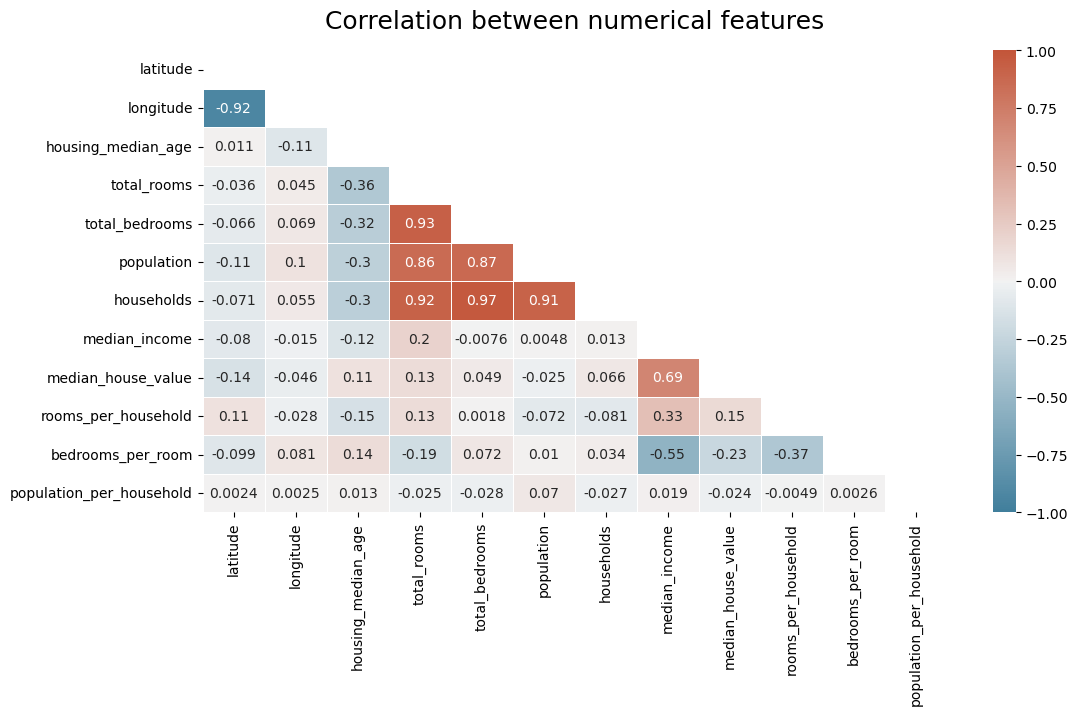

In [223]:
plot_correlation_heatmap(subset_data, "Correlation between numerical features")

What are the two features that have the biggest correlation in this dataset?

In [224]:
# Extract the correlation coefficients from the correlation matrix (I use the absolute value to not miss any correlation)
ordered_correlations = abs(corr_matrix).unstack().sort_values(ascending=False)
ordered_correlations

latitude                  latitude                    1.000000
longitude                 longitude                   1.000000
bedrooms_per_room         bedrooms_per_room           1.000000
rooms_per_household       rooms_per_household         1.000000
median_house_value        median_house_value          1.000000
                                                        ...   
longitude                 population_per_household    0.002476
latitude                  population_per_household    0.002366
population_per_household  latitude                    0.002366
total_bedrooms            rooms_per_household         0.001765
rooms_per_household       total_bedrooms              0.001765
Length: 144, dtype: float64

In [225]:
print(ordered_correlations[ordered_correlations < 1])

households                total_bedrooms              0.974366
total_bedrooms            households                  0.974366
                          total_rooms                 0.927058
total_rooms               total_bedrooms              0.927058
longitude                 latitude                    0.924664
                                                        ...   
                          population_per_household    0.002476
latitude                  population_per_household    0.002366
population_per_household  latitude                    0.002366
total_bedrooms            rooms_per_household         0.001765
rooms_per_household       total_bedrooms              0.001765
Length: 132, dtype: float64


The two variables 'total_bedrooms' and 'households' have the greatest correlation between them.

# Make median_house_value binary

We need to turn the median_house_value variable from numeric into binary.

Let's create a variable above_average which is 1 if the median_house_value is above its mean value and 0 otherwise.

In [226]:
# Calculate the mean of 'median_house_value'
median_house_value_mean = subset_data["median_house_value"].mean()
median_house_value_mean

206855.81690891474

In [227]:
subset_data["above_average"] = np.where(
    subset_data["median_house_value"] > median_house_value_mean, 1, 0
)

# Split the data

Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.

Make sure that the target value (median_house_value) is not in your dataframe.

In [228]:
# First generate the full training dataset and the test dataset
full_train, test = train_test_split(subset_data, test_size=0.2, random_state=42)

In [229]:
# Then separate the full training dataset into train and validation datasets. We have to adjust the proportions:
# we need 20% of the total number of rows from the 80% of values, which means we are looking for 0.25 proportion for the validation dataset
train, val = train_test_split(full_train, test_size=0.25, random_state=42)

In [230]:
train, val, test, y_train, y_val, y_test = separate_target_from_features(
    train, val, test, "above_average"
)

In [231]:
# I also remove the 'median_house_value' from the three datasets
del train["median_house_value"]
del val["median_house_value"]
del test["median_house_value"]

# Question 3

Calculate the mutual information score between above_average and ocean_proximity . Use the training set only.

Round it to 2 decimals using round(score, 2)

What is their mutual information score?

In [234]:
# Here I use the full_train dataset and split it into train and val again
train_mutual, val_mutual = train_test_split(full_train, test_size=0.25, random_state=42)
round(
    mutual_info_score(train_mutual["above_average"], train_mutual["ocean_proximity"]), 2
)

0.1

# Question 4

Now let's train a logistic regression

Remember that we have one categorical variable ocean_proximity in the data. Include it using one-hot encoding.

Fit the model on the training dataset.

To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)

Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [239]:
# Extract feature list from training dataset
feature_list = train.columns.tolist()

# Calculate the accuracy for training, validation and test datasets
train_acc, val_acc, test_acc = logistic_regression_accuracy(
    feature_list=feature_list,
    train_df=train,
    val_df=val,
    test_df=test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
)

The features used are ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household'].
Training Accuracy Score 0.83
Validation Accuracy Score 0.836
Test Accuracy Score 0.835


In [241]:
print(f"The accuracy on the validation dataset is equal to: {round(val_acc,2)}.")

The accuracy on the validation dataset is equal to: 0.84.


# Question 5

Let's find the least useful feature using the feature elimination technique.
- Train a model with all these features (using the same parameters as in Q4).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.
- Which of following feature has the smallest difference?

Features:
- total_rooms
- total_bedrooms
- population
- households

In [242]:
features_to_keep = ["total_rooms", "total_bedrooms", "population", "households"]

In [243]:
score_train_all, score_val_all, score_test_all = logistic_regression_accuracy(
    features_to_keep, train, val, test, y_train, y_val, y_test
)

The features used are ['total_rooms', 'total_bedrooms', 'population', 'households'].
Training Accuracy Score 0.83
Validation Accuracy Score 0.836
Test Accuracy Score 0.835


In [244]:
features_without_total_rooms = ["total_bedrooms", "population", "households"]

In [245]:
score_train_all, score_val_all, score_test_all = logistic_regression_accuracy(
    features_without_total_rooms, train, val, test, y_train, y_val, y_test
)

The features used are ['total_bedrooms', 'population', 'households'].
Training Accuracy Score 0.83
Validation Accuracy Score 0.836
Test Accuracy Score 0.835


In [246]:
features_without_total_bedrooms = ["total_rooms", "population", "households"]

In [247]:
score_train_all, score_val_all, score_test_all = logistic_regression_accuracy(
    features_without_total_bedrooms, train, val, test, y_train, y_val, y_test
)

The features used are ['total_rooms', 'population', 'households'].
Training Accuracy Score 0.83
Validation Accuracy Score 0.836
Test Accuracy Score 0.835


In [248]:
features_without_population = ["total_rooms", "total_bedrooms", "households"]

In [249]:
score_train_all, score_val_all, score_test_all = logistic_regression_accuracy(
    features_without_population, train, val, test, y_train, y_val, y_test
)

The features used are ['total_rooms', 'total_bedrooms', 'households'].
Training Accuracy Score 0.83
Validation Accuracy Score 0.836
Test Accuracy Score 0.835


In [250]:
features_without_households = ["total_rooms", "total_bedrooms", "population"]

In [251]:
score_train_all, score_val_all, score_test_all = logistic_regression_accuracy(
    features_without_households, train, val, test, y_train, y_val, y_test
)

The features used are ['total_rooms', 'total_bedrooms', 'population'].
Training Accuracy Score 0.83
Validation Accuracy Score 0.836
Test Accuracy Score 0.835


In [252]:
# Calculate the difference in accuracy for the validation dataset for each feature compared to all features:
diff_total_rooms = 0.71 - 0.628
diff_total_bedrooms = 0.71 - 0.661
diff_population = 0.71 - 0.657
diff_households = 0.71 - 0.672

In [253]:
# Print the differences:
print(
    f"The accuracy difference between all features and total_rooms is: {round(diff_total_rooms,2)}."
)
print(
    f"The accuracy difference between all features and total_bedrooms is: {round(diff_total_bedrooms,2)}."
)
print(
    f"The accuracy difference between all features and households is: {round(diff_households,2)}."
)
print(
    f"The accuracy difference between all features and population is: {round(diff_population,2)}."
)

The accuracy difference between all features and total_rooms is: 0.08.
The accuracy difference between all features and total_bedrooms is: 0.05.
The accuracy difference between all features and households is: 0.04.
The accuracy difference between all features and population is: 0.05.


The "households" variable presents the smallest difference compared to all features.

# Question 6

For this question, we'll see how to use a linear regression model from Scikit-Learn

We'll need to use the original column 'median_house_value'. Apply the logarithmic transformation to this column.

Fit the Ridge regression model (model = Ridge(alpha=a, solver="sag", random_state=42)) on the training data.

This model has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10]

Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

In [254]:
# Since we need to use the original median_house_value column, we start from the original data

# First generate the full training dataset and the test dataset
full_train, test = train_test_split(subset_data, test_size=0.2, random_state=42)

# Then separate the full training dataset into train and validation datasets. We have to adjust the proportions:
# we need 20% of the total number of rows from the 80% of values, which means we are looking for 0.25 proportion for the validation dataset
train, val = train_test_split(full_train, test_size=0.25, random_state=42)

In [260]:
train, val, test, y_train, y_val, y_test = separate_target_from_features(
    train_df=train,
    val_df=val,
    test_df=test,
    target_name="median_house_value",
    log_transformation=True,
)

In [262]:
# Also delete the 'above_average' column (data leakage)
del train["above_average"]
del val["above_average"]
del test["above_average"]

In [266]:
# Fit a Ridge regression model on the training dataset with the list of alpha parameters
rmse_val_list = []
alpha_list = [0, 0.01, 0.1, 1, 10]

for alpha in alpha_list:
    rmse_value = rmse_validation_ridge(
        train_df=train,
        val_df=val,
        y_train=y_train,
        y_val=y_val,
        alpha=alpha,
    )
    rmse_val_list.append(rmse_value)

C:\Users\Melanie\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The obtained RMSE on the validation dataset with alpha=0 is 0.523.


C:\Users\Melanie\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The obtained RMSE on the validation dataset with alpha=0.01 is 0.523.


C:\Users\Melanie\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The obtained RMSE on the validation dataset with alpha=0.1 is 0.523.


C:\Users\Melanie\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The obtained RMSE on the validation dataset with alpha=1 is 0.523.
The obtained RMSE on the validation dataset with alpha=10 is 0.523.


C:\Users\Melanie\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [267]:
rmse_val_list

[0.523, 0.523, 0.523, 0.523, 0.523]

The smallest RMSE value is obtained with alpha=0.